In [1]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

import sklearn.metrics as metrics
import random

/Users/suzannenie/Library/Python/myvenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [3]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = 'CheXpert-v1.0-small/train.csv'
pathFileValid = 'CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
device = torch.device('cpu')

In [4]:
# initialize and load the model
model = DenseNet121(nnClassCount)
model = torch.nn.DataParallel(model)

/Users/suzannenie/Library/Python/myvenv3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/suzannenie/Library/Python/myvenv3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model_path = "/Users/suzannenie/Documents/Programming_projects/Chest_CT/Chexpert/model_ones_3epoch_densenet.tar"
pretrainload = torch.load(model_path, map_location=device)
model.load_state_dict(pretrainload['state_dict'])

<All keys matched successfully>

In [12]:
class HeatmapGenerator ():
    
    #---- Initialize heatmap generator
    #---- pathModel - path to the trained densenet model
    #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
    #---- nnClassCount - class count, 14 for chxray-14

 
    def __init__ (self, pathModel, nnClassCount, transCrop):
       
        #---- Initialize the network
        model = DenseNet121(nnClassCount)
        model = torch.nn.DataParallel(model)
        
        modelCheckpoint = torch.load(pathModel, map_location=device)
        model.load_state_dict(modelCheckpoint['state_dict'])

        self.model = model
        self.model.eval()
        
        #---- Initialize the weights
        self.weights = list(self.model.module.densenet121.features.parameters())[-2]

        #---- Initialize the image transform
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transformList = []
        transformList.append(transforms.Resize((transCrop, transCrop)))
        transformList.append(transforms.ToTensor())
        transformList.append(normalize)  
        self.transformSequence = transforms.Compose(transformList)
    
    #--------------------------------------------------------------------------------
     
    def generate (self, pathImageFile, pathOutputFile, transCrop):
        
        #---- Load image, transform, convert 
        with torch.no_grad():
 
            imageData = Image.open(pathImageFile).convert('RGB')
            imageData = self.transformSequence(imageData)
            imageData = imageData.unsqueeze_(0)
            # if use_gpu:
            #     imageData = imageData.cuda()
            l = self.model(imageData)
            output = self.model.module.densenet121.features(imageData)
            print(l.shape)
            print(torch.max(l,1))
            label = class_names[torch.max(l,1)[1]]
            #---- Generate heatmap
            heatmap = None
            for i in range (0, len(self.weights)):
                map = output[0,i,:,:]
                if i == 0: heatmap = self.weights[i] * map
                else: heatmap += self.weights[i] * map
                npHeatmap = heatmap.cpu().data.numpy()

        #---- Blend original and heatmap 
                
        imgOriginal = cv2.imread(pathImageFile, 1)
        imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
        cam = npHeatmap / np.max(npHeatmap)
        cam = cv2.resize(cam, (transCrop, transCrop))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
        img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.title(label)
        plt.imshow(img)
        plt.plot()
        plt.axis('off')
        # plt.savefig(pathOutputFile)
        plt.show()

torch.Size([1, 14])
torch.return_types.max(
values=tensor([0.6263]),
indices=tensor([3]))


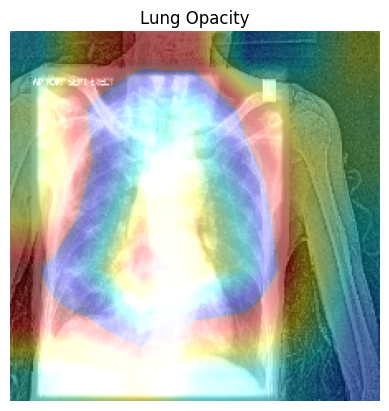

In [13]:
pathInputImage = 'Chexpert/CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg'
pathOutputImage = 'heatmap_view1_frontal.png'

h = HeatmapGenerator(model_path, nnClassCount, imgtransCrop)

h.generate(pathInputImage, pathOutputImage, imgtransCrop)